In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import scipy.io
mat_dict = scipy.io.loadmat('StevensonV2.mat')

In [3]:
mat_dict.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Publication', 'timeBase', 'spikes', 'time', 'handVel', 'handPos', 'target', 'startBins', 'targets', 'startBinned'])

In [4]:
X0 = mat_dict['spikes'].T
y0 = mat_dict['handPos'][0,:]

In [5]:
nt=X0.shape[0]
nneuron=X0.shape[1]
print('Number of time bins = {}'.format(nt))
print('Number of neurons = {}'.format(nneuron))

Number of time bins = 15536
Number of neurons = 196


In [6]:
t0=np.array(mat_dict['time'])
t=t0[0]
t.shape

(15536,)

In [7]:
for i in range(1,15536):
    tsamp0=t[i]-t[i-1]
tsamp=np.mean(tsamp0)
tsamp

0.049999999999954525

In [8]:
ttol=np.max(t)-np.min(t)
ttol

776.75

In [9]:
from sklearn import linear_model 
n=nt//2
X_tr=X0[:n,:]
y_tr=y0[:n]
X_ts=X0[n:,:]
y_ts=y0[n:]

In [10]:
import sklearn.linear_model
regr = linear_model.LinearRegression()
regr.fit(X_tr,y_tr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [11]:
y_tr_pred = regr.predict(X_tr)
RSS_tr = np.mean((y_tr_pred-y_tr)**2)/(np.std(y_tr)**2)
print("RSS in training data = {0:f}".format(RSS_tr))

RSS in training data = 0.457975


In [12]:
y_ts_pred= regr.predict(X_ts)
RSS_ts = np.mean(((y_ts_pred-y_ts)**2)/(np.std(y_ts)**2))
print("RSS in testing data = {0:f}".format(RSS_ts))

RSS in testing data = 169375944846410874880.000000


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


<Container object of 3 artists>

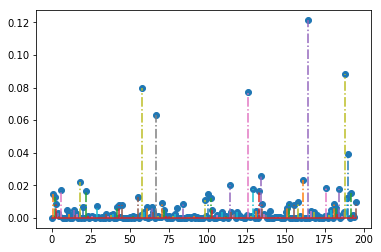

In [18]:
ym=np.mean(y0)
syy=np.mean((y0-ym)**2)
Rsq=np.empty(nneuron)
for k in range(nneuron):
    Xm=np.mean(X0[:,k])
    sxy=np.mean((X0[:,k]-Xm)*(y0-ym))
    sxx=np.mean((X0[:,k]-Xm)**2)
    Rsq[k]=sxy**2/(sxx*syy)
    #natt=np.array(range(1,nneuron+1))
plt.stem(Rsq,'-.')

In [24]:
d=50
Isel=np.argsort(-Rsq)[:d]
top=np.argsort(-Rsq)[:10]
print("The neurons with the ten highest R^2 values=")
for i in top:
    value=Rsq[i]
    print("num=%d, value=%s"%(i,Rsq[i]))

The neurons with the ten highest R^2 values=
num=164, value=0.121277618685
num=188, value=0.0884243959258
num=58, value=0.0798267929212
num=126, value=0.0773731593927
num=67, value=0.0628948377756
num=190, value=0.0392468939749
num=134, value=0.0257381828934
num=161, value=0.023263228804
num=18, value=0.0223241369116
num=114, value=0.0199858675092


In [26]:
x1=X0[:,Isel]
ntr=nt//2
xtr = x1[:ntr]
ytr = y0[:ntr]
xts = x1[ntr:]
yts = y0[ntr:]
regr = linear_model.LinearRegression()
regr.fit(xtr,ytr)
yts_pred = regr.predict(xts)
RSS_samp = np.mean((yts_pred-yts)**2)
RSSts = np.mean((yts_pred-yts)**2)/(np.std(yts)**2)
print('Test RSS per sample = %f, Normalized test RSS = %f' %(RSS_samp, RSSts))


Test RSS per sample = 0.000969, Normalized test RSS = 0.498469


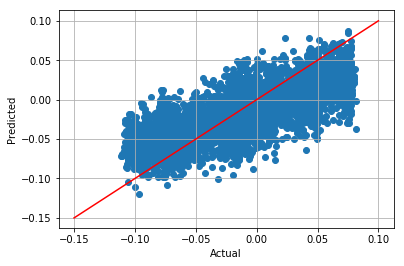

In [28]:
plt.scatter(yts,yts_pred)
plt.plot([-0.15,0.1],[-0.15,0.1],'r')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid()

In [37]:
# Create a k-fold object
nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

# Model orders to be tested
dtest = np.arange(10,200,10)
nd = len(dtest)
RSSts = np.zeros((nd,nfold))
for nsplit, Ind in enumerate(kf.split(X0)):
    Itr, Its = Ind
    xtr = X0[Itr]
    ytr = y0[Itr]
    xts = X0[Its]
    yts = y0[Its]
    for it, d in enumerate (dtest):
        Isel = np.argsort(-Rsq)[:d]
        xtr1 = xtr[:,Isel]
        xts1 = xts[:,Isel]
        regr = linear_model.LinearRegression()
        regr.fit(xtr1,ytr)
        yts_pred = regr.predict(xts1)
        RSSts[it,nsplit] = np.mean((yts_pred-yts)**2)

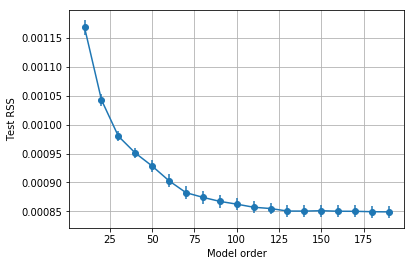

In [38]:
RSS_mean = np.mean(RSSts,axis=1)
RSS_std = np.std(RSSts,axis=1) / np.sqrt(nfold-1)
plt.errorbar(dtest, RSS_mean, yerr=RSS_std, fmt='o-')
plt.xlabel('Model order')
plt.ylabel('Test RSS')
plt.grid()

The estimated model order is %d, the mean test RSS per sample at the optimal d


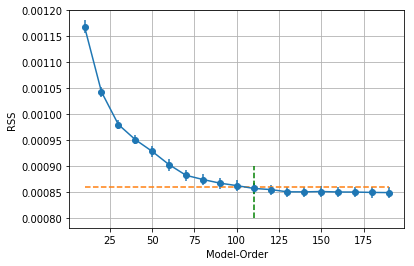

In [40]:
d0 = np.argmin(RSS_mean)
RSS_tgt = RSS_mean[d0] + RSS_std[d0]
I = np.where(RSS_mean <= RSS_tgt)[0]
i_optimal = I[0]
d_optimal = dtest[i_optimal]
plt.grid()
plt.errorbar(dtest, RSS_mean, yerr=RSS_std, fmt='o-')
plt.plot([dtest[0],dtest[d0]],[RSS_tgt,RSS_tgt], '--')
plt.plot([d_optimal,d_optimal],[0.0008,0.0009],'g--')
plt.xlabel('Model-Order')
plt.ylabel('RSS')
print( 'The estimated model order is %d, the mean test RSS per sample at the optimal d')